#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

# Настройка, чтобы текст в ячейке отображался весь.
pd.set_option('display.max_colwidth', None)
# Настроим 2 знака после точки в float и разделение запятой тысячные до запятой.
pd.set_option('display.float_format', '{:,.2f}'.format)
# Уберем сообщения об ошибке -цепного присваивания.
pd.options.mode.chained_assignment = None


# Выгрузим модели для обучения.
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor as dtr
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor


# импортируем автокорреляционную функцию (ACF)
from statsmodels.graphics.tsaplots import plot_acf

# Выгрузим показатели эффективности модели.
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose

# импортируем библиотеки для кодирования и подготовки данных, а так же поиска лучших гиперпараметров.
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV,TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin

# Для построения графиков

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
plt. style. use('dark_background')


#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9
rcParams["figure.autolayout"] = True


# Для вывода результатов.
from pprint import pprint
from IPython.display import display

In [2]:
# Прочитаем файл данных.
file_list=['datasets/taxi.csv']


try:
  dataframe = pd.read_csv(file_list[0],index_col=[0],converters={'datetime':pd.to_datetime})
except:
  dataframe = pd.read_csv('https://code.s3.yandex.net/'+file_list[0],index_col=[0],converters={'datetime':pd.to_datetime})
dataframe. sort_index(inplace=True)
df=dataframe.copy(deep=True)

In [3]:
# Посмотрим общую информацию о датафрейме.

display (df. info())
df. head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
# Посмотрим период временного ряда по датам.

df. index. min(), df. index. max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

In [5]:
# Выведем описание данных.

df. describe ()

,num_orders
count,"26,496.00"
mean,14.07
std,9.21
min,0.00
25%,8.00
50%,13.00
75%,19.00
max,119.00


In [6]:
# Проверим датафрейм на монотонность данных.

df.index.is_monotonic

<ipython-input-6-3ee5f32e02d0>:3: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic


True

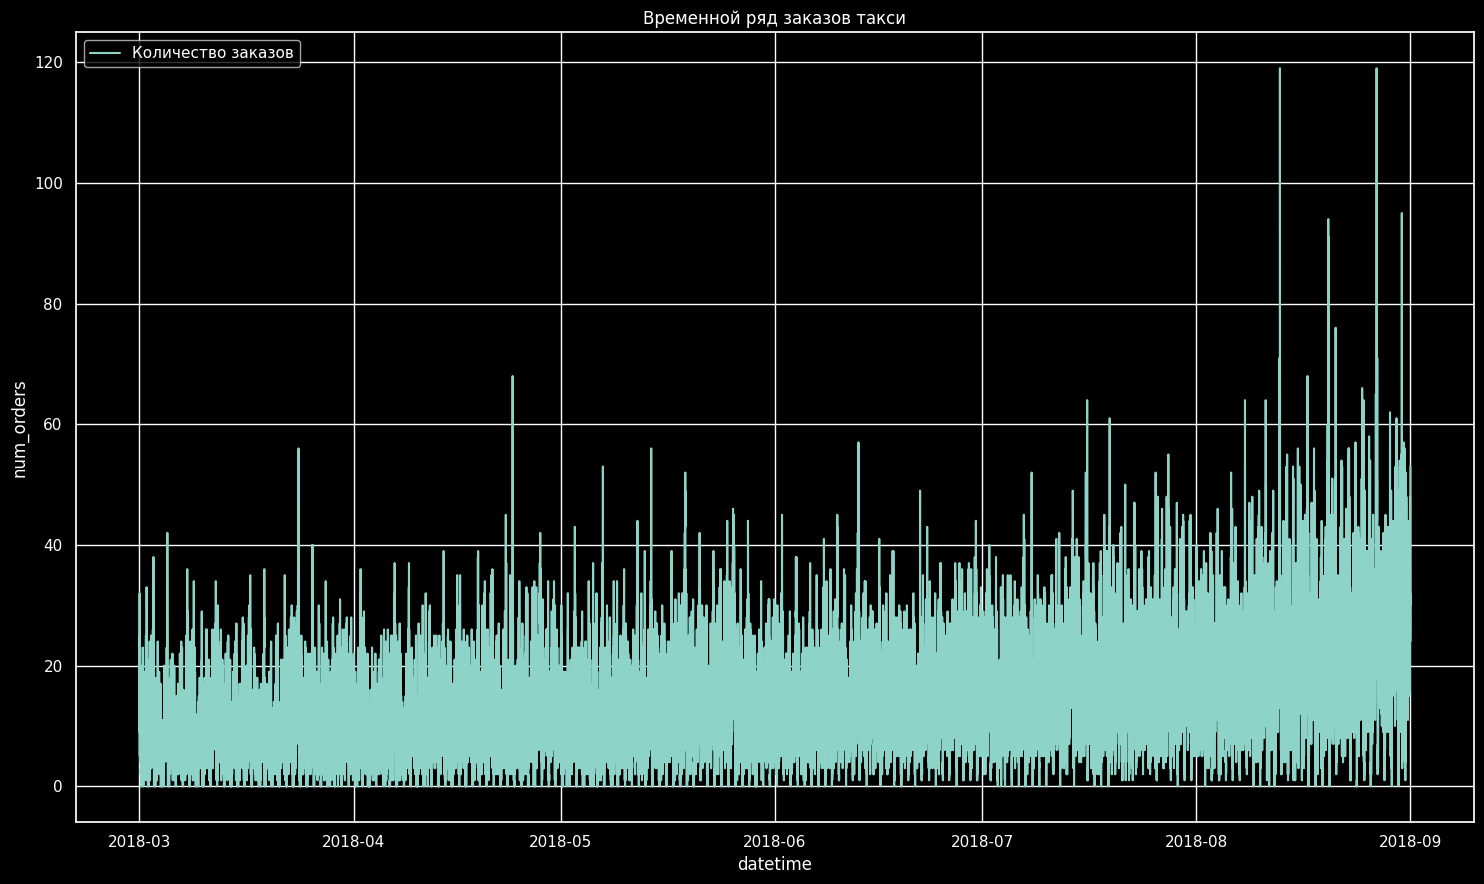

In [7]:
# Построим график.

sns.lineplot(x=df.index,
             y='num_orders',
             data=df). set(title='Временной ряд заказов такси')
plt.legend(['Количество заказов'],loc=2)
plt. show()

In [8]:
# Сделаем ресэмблирование данных с 10 минутного шага га часовой.

df=df.resample ('1H'). sum()
display (df.head())
df. shape

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


(4416, 1)

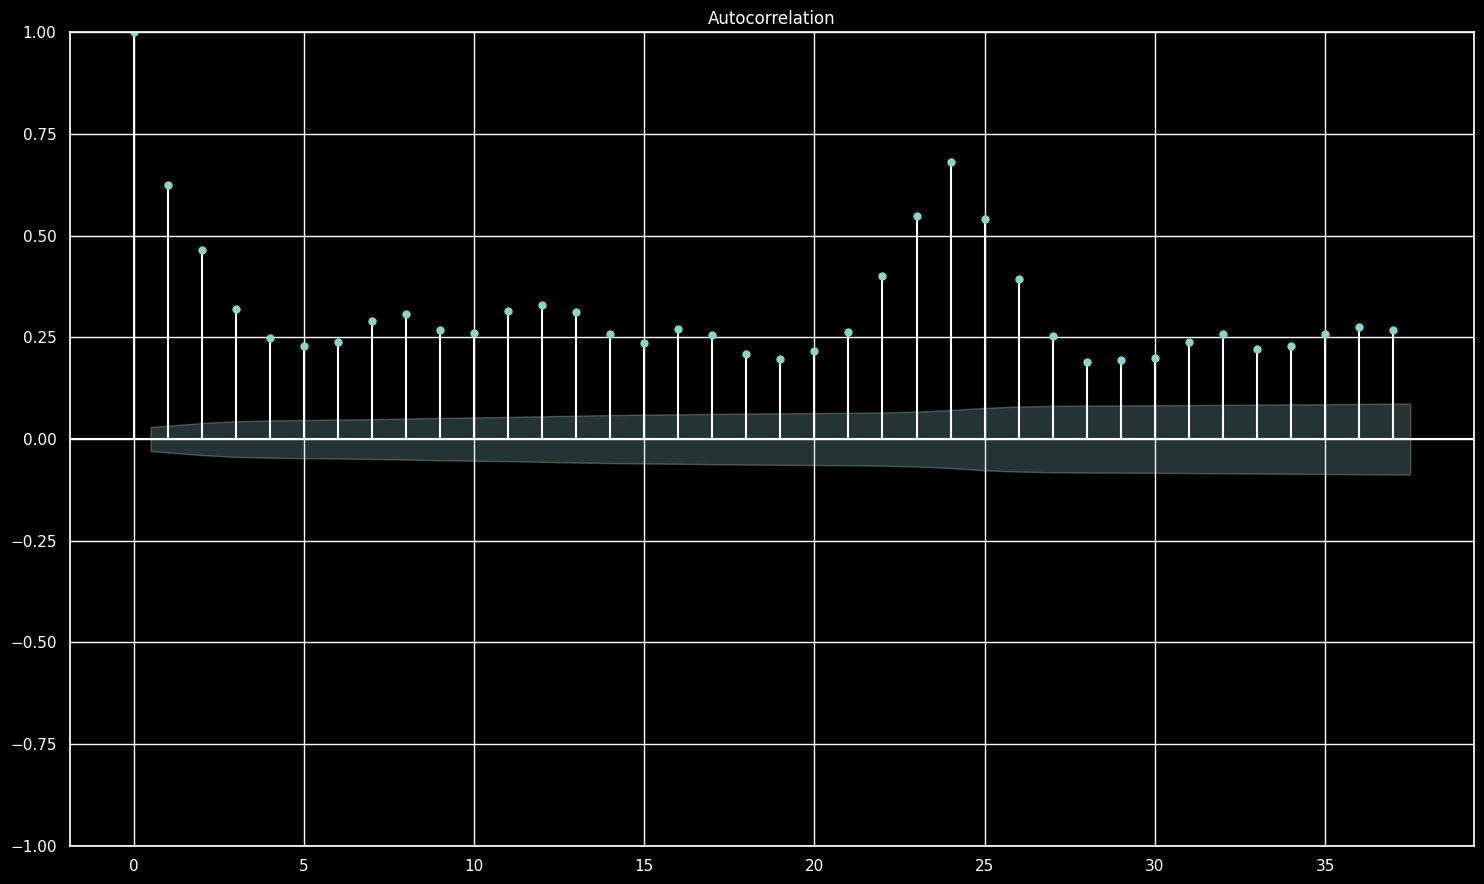

In [9]:
# применим функцию автокорреляции к нашему набору данных.

plot_acf(df)
plt.show()

Автокорреляция позволяет выявлять тренд и сезонность, а также используется при подборе параметров моделей. В частности, мы видим, что лаг 24 сильнее коррелирует с исходным рядом, чем соседние лаги 23 и 25. То же самое можно сказать и про лаг 1. Такая автокорреляция позволяет предположить наличие сезонных колебаний.

То, что корреляция постоянно положительная говорит о наличии тренда. Все это подтвердится, когда мы разложим временной ряд на компоненты.

Также замечу, что синяя граница позволяет оценить статистическую значимость корреляции. Если столбец выходит за ее пределы, то автокорреляция достаточно сильна и ее можно использовать при построении модели.

Вывод:

Из датафрейма следует, что у нас есть данные по числу заказов такси с 1 марта 2018 года, по 31 августа 2018 г. Временной шаг составляет -10 мин. Среднее количество заказов за этот промежуток времени равно 13 шт. Максимальное количество заказов равно 119 шт.

## Анализ

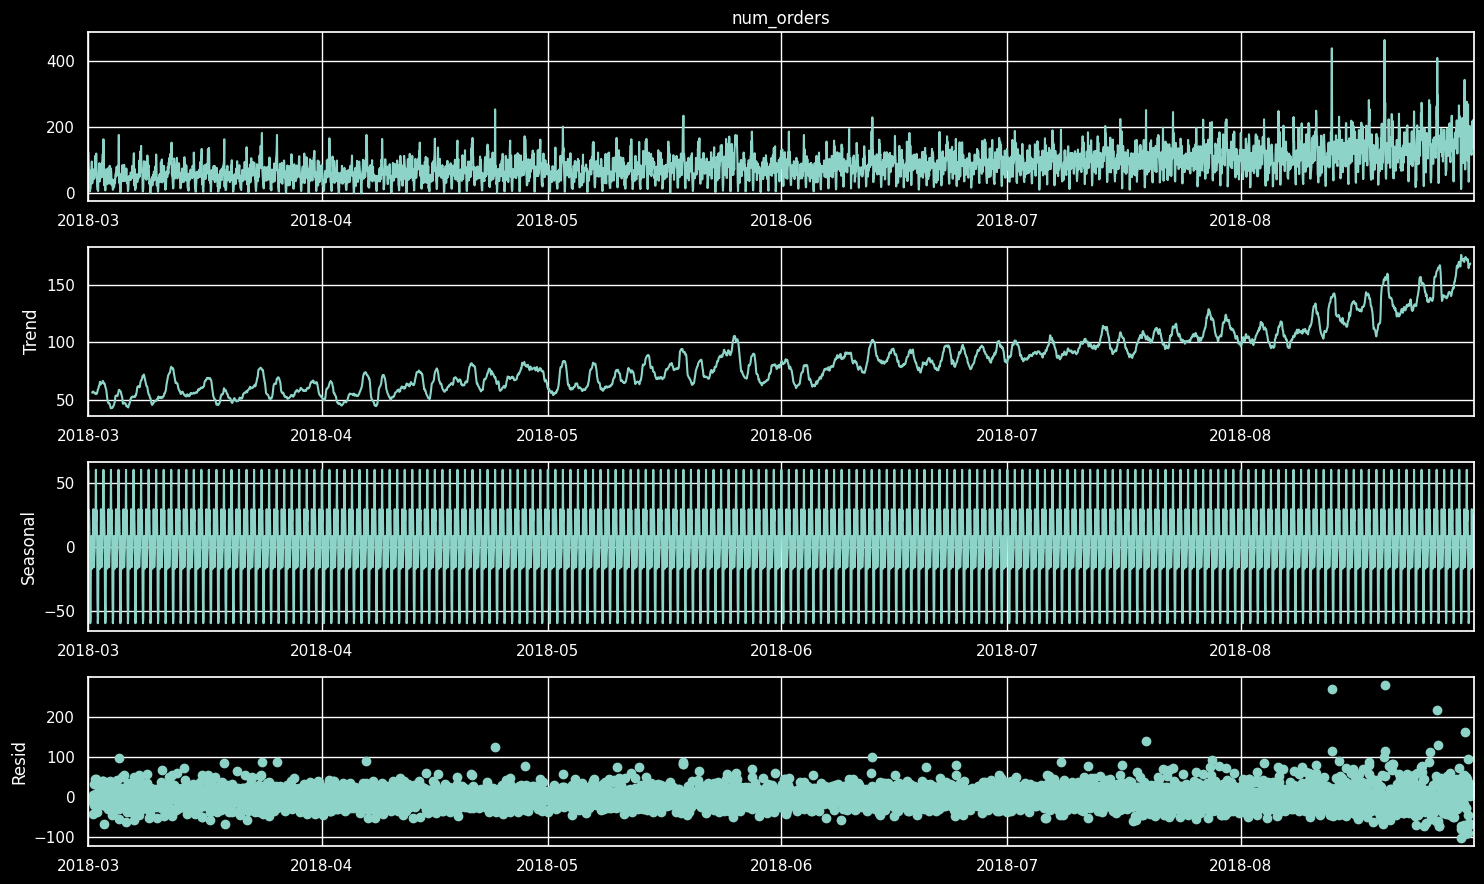

In [10]:
# Разобъем временной ряд на составляющие.

result = seasonal_decompose(df['num_orders'])
result.plot()
plt.show()

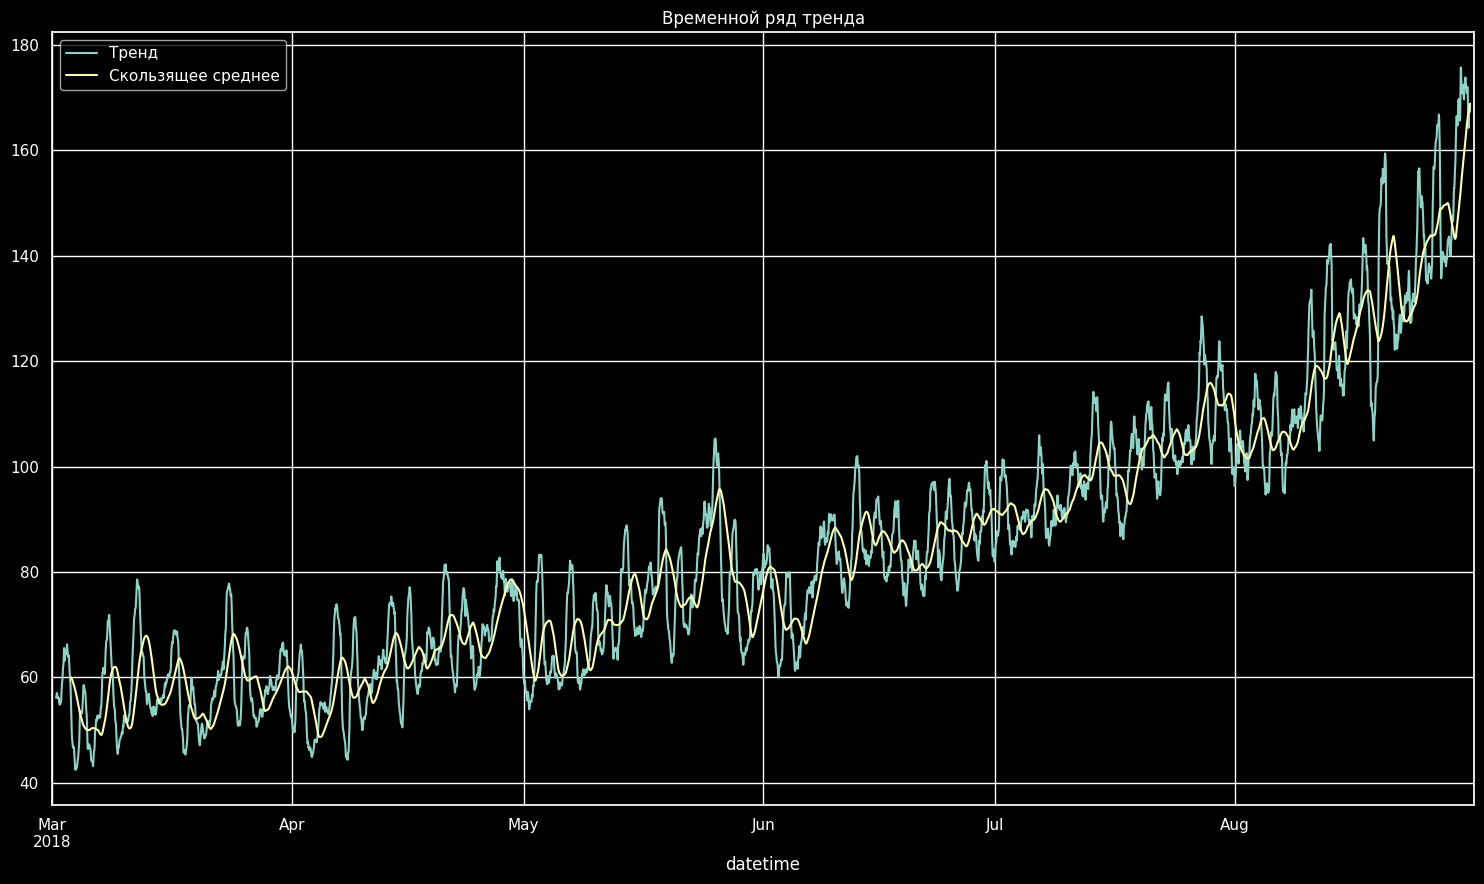

In [11]:
# Наложим график скользящего среднего на график восходящего тренда.

result.trend.plot(). set(title='Временной ряд тренда')
result.trend.rolling(48). mean(). plot()
plt.legend(['Тренд','Скользящее среднее'],loc=2)
plt. show()

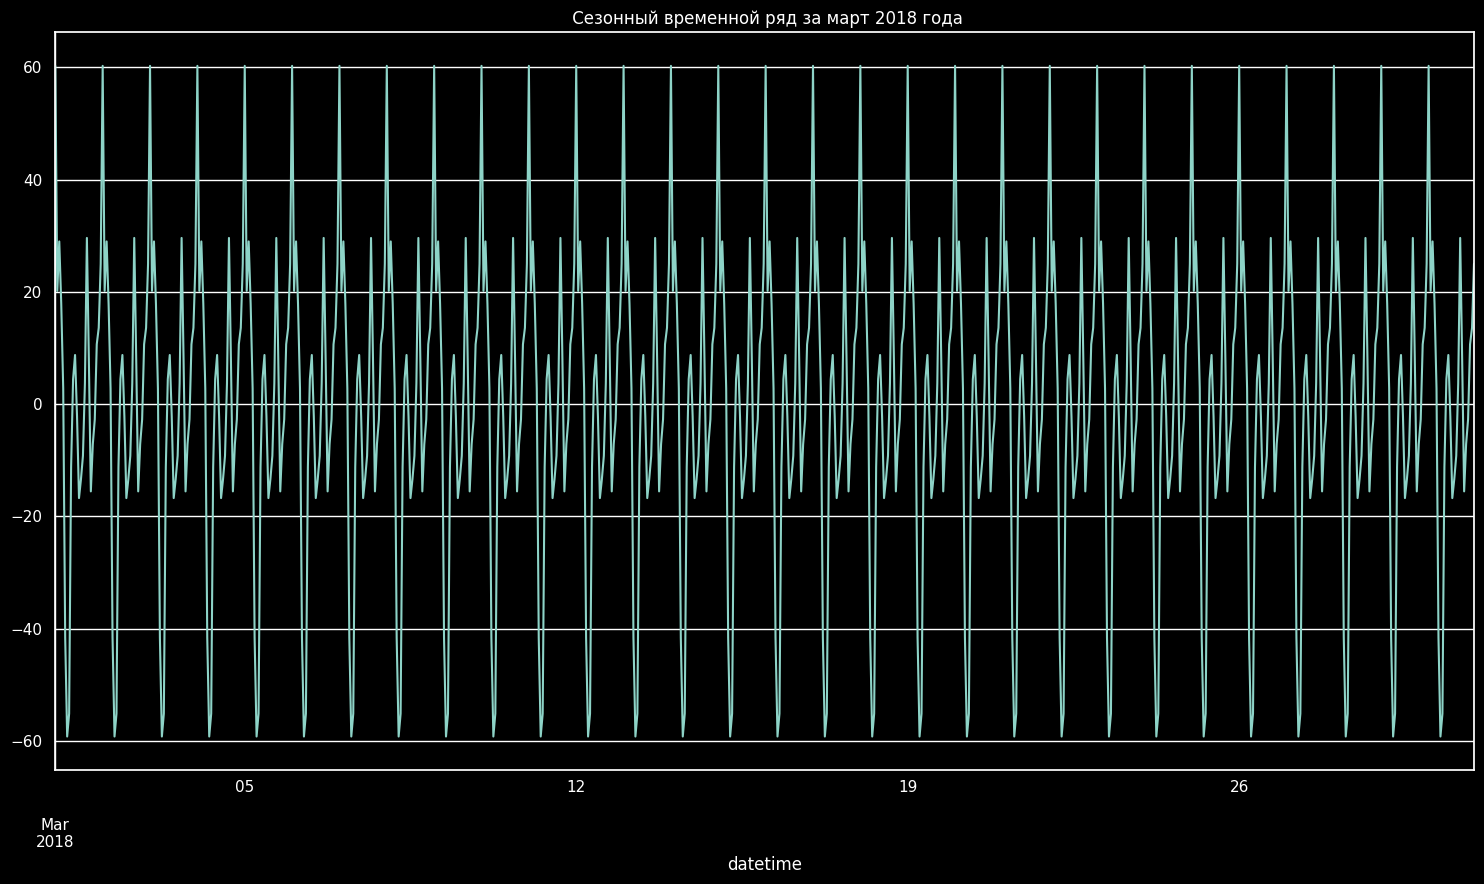

In [12]:
# Посмотрим на частоту сезонной составляющей временного ряда.

result. seasonal['2018-03-01 00:00':'2018-03-30 23:00'].plot().set(title=' Сезонный временной ряд за март 2018 года')
plt. show()

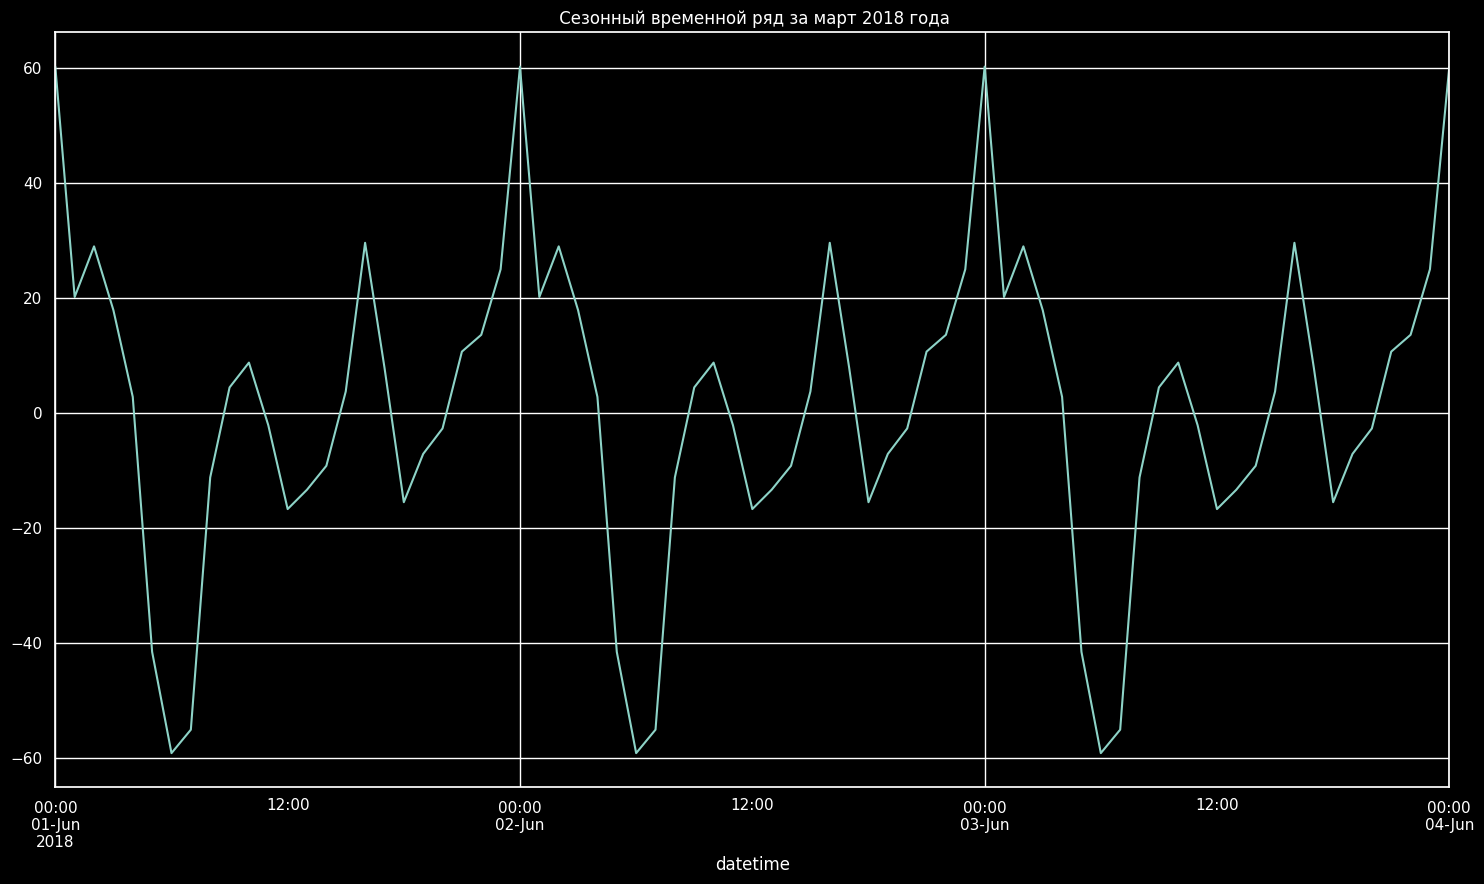

In [13]:
# Уменьшим рассматриваемый период,чтобы увидеть частотную составляющую ближе.

result. seasonal['2018-06-01 00:00':'2018-06-04 00:00'].plot().set(title=' Сезонный временной ряд за март 2018 года')
plt. show()

In [14]:
# создадим список рабочих дней в месяце.


pd. date_range(df. index. min(), df. index. max(), freq='B')

DatetimeIndex(['2018-03-01', '2018-03-02', '2018-03-05', '2018-03-06',
               '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-12',
               '2018-03-13', '2018-03-14',
               ...
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-27', '2018-08-28', '2018-08-29',
               '2018-08-30', '2018-08-31'],
              dtype='datetime64[ns]', length=132, freq='B')

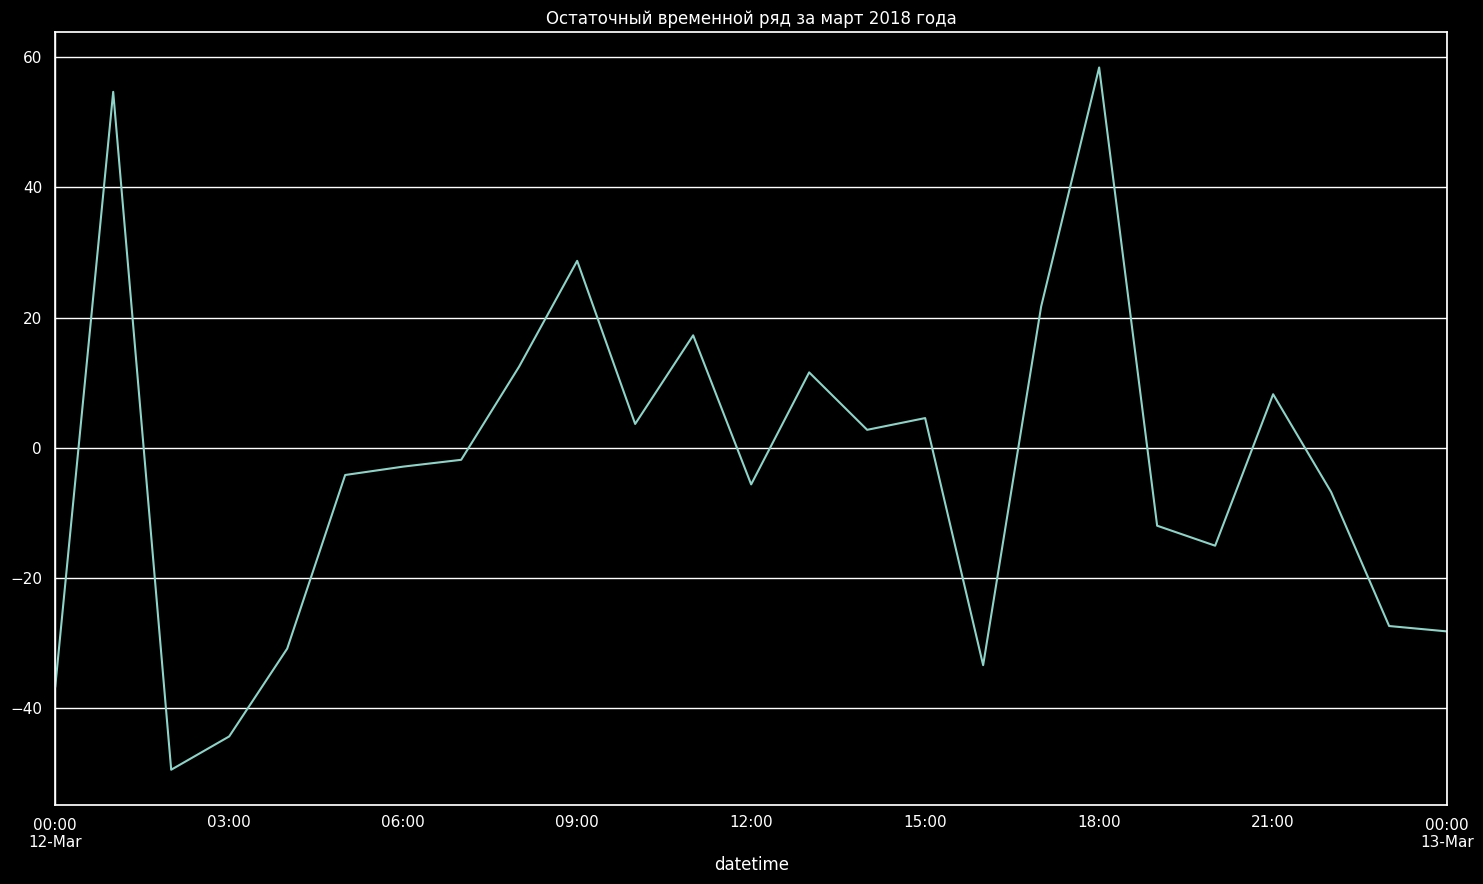

In [15]:
# Посмотрим на дневной график остатков.


result. resid['2018-03-12 00:00':'2018-03-13 00:00'].plot().set(title='Остаточный временной ряд за март 2018 года')
plt. show()

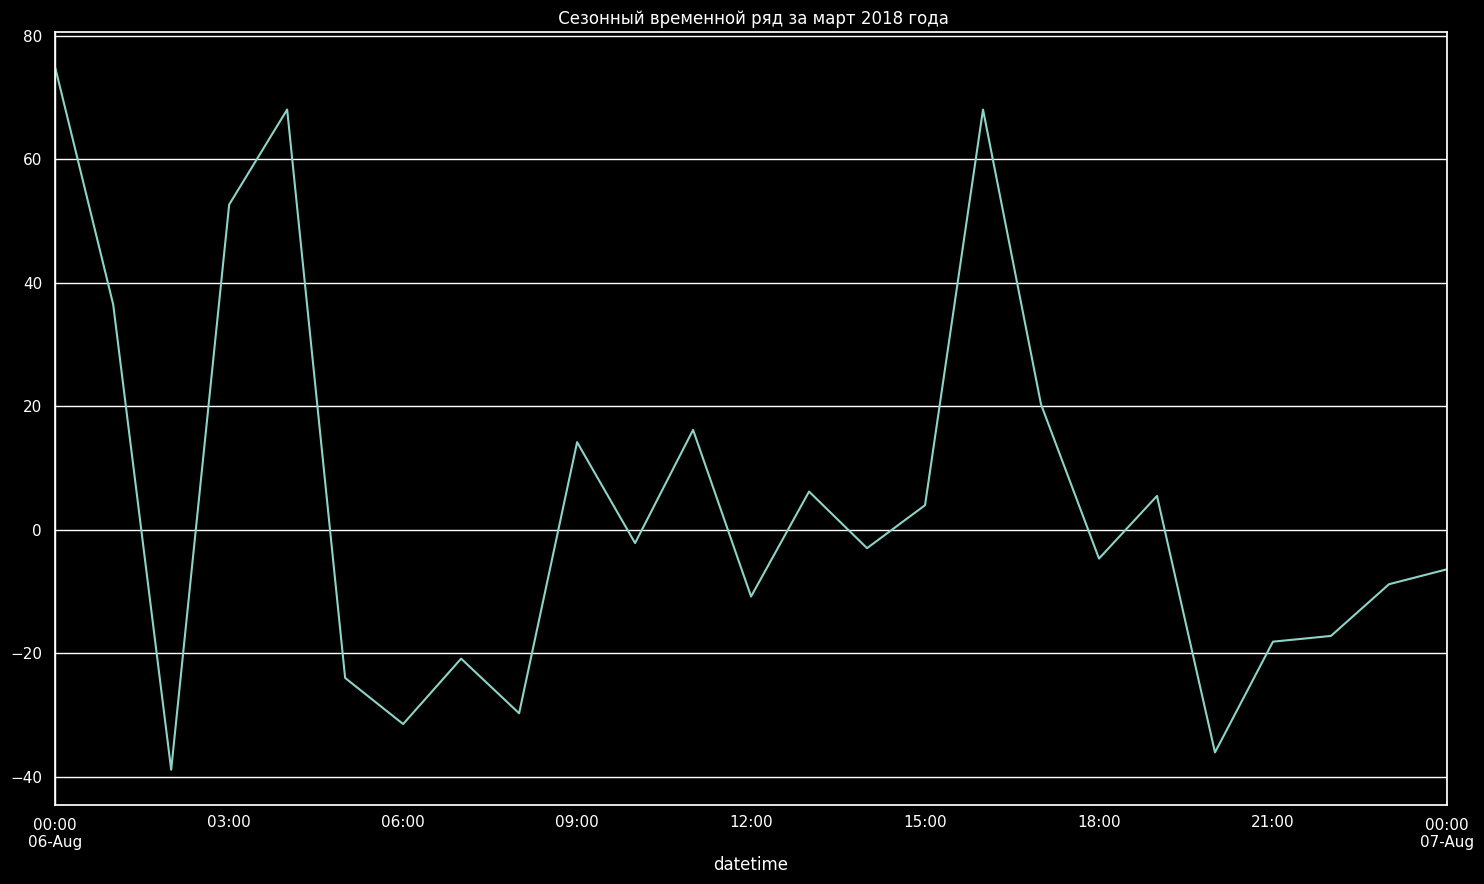

In [16]:
# Посмотрим на дневной график остатков другого дня для сравнения.

result. resid['2018-08-06 00:00':'2018-08-07 00:00'].plot().set(title=' Сезонный временной ряд за март 2018 года')
plt. show()

Вывод

Тренд восходящий, сезонность присутствует в течении дня. Пики количества заказов приходятся на утро с 9-11, конец рабочего дня 16-18 и максимальное значение в районе полуночи.В целом временной ряд не стационарен, т. к. со временем меняется его среднее значение и дисперсия. Стационарная только сезонная составляющая.

## Обучение

In [17]:
# Создадим стационарный временной ряд из имеющегося.

taxi_fr=df.copy(deep=True)
taxi_fr['num_orders']=df['num_orders']- df['num_orders'].shift(fill_value=0)

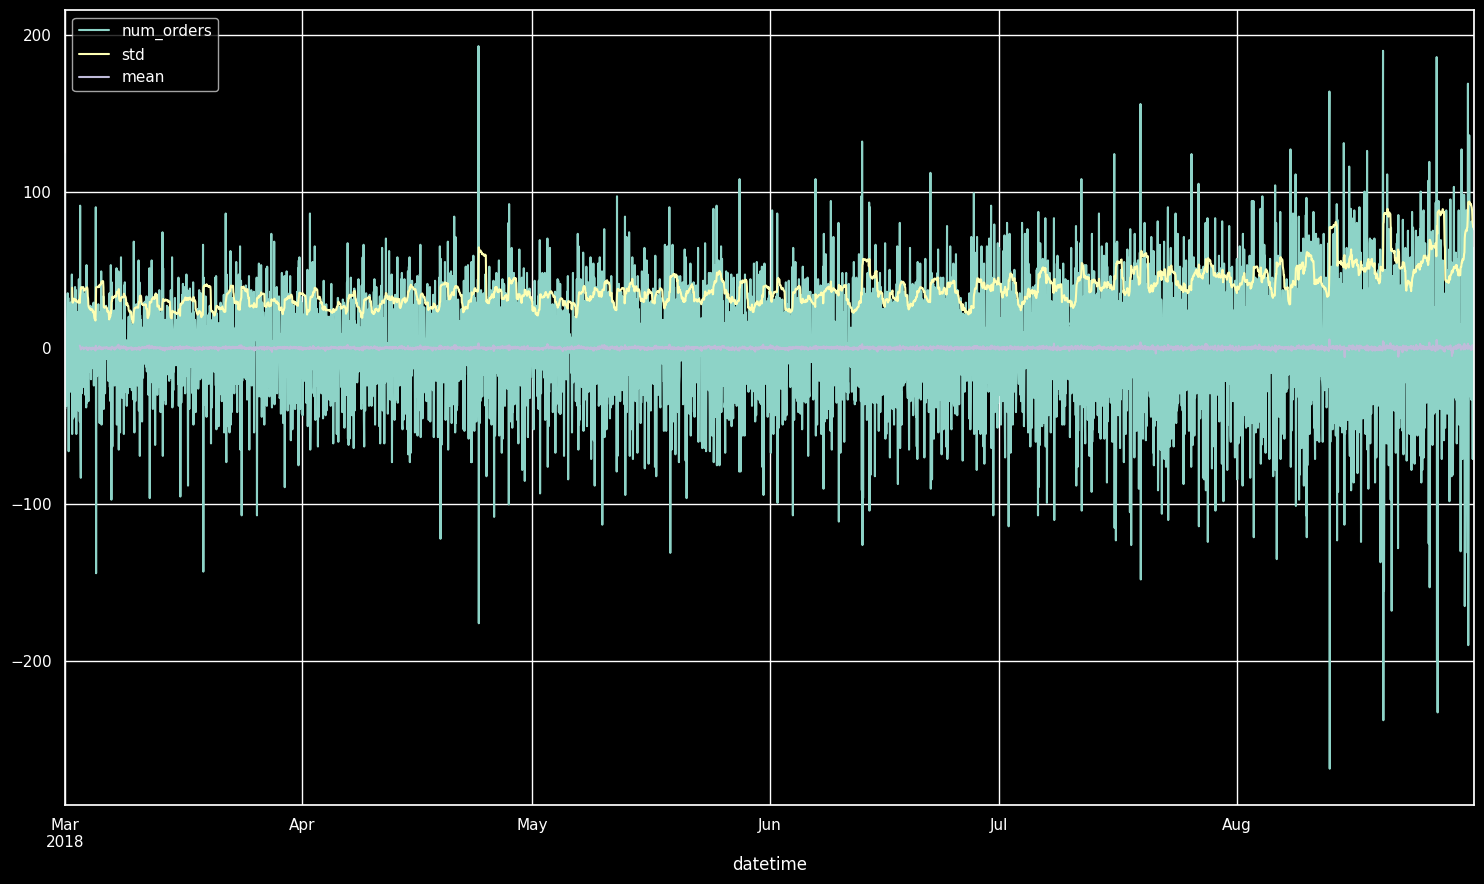

In [18]:
# Построим график.

taxi_fr['mean'] = taxi_fr['num_orders'].rolling(48).mean()
taxi_fr['std'] = taxi_fr['num_orders'].rolling(24).std()
taxi_fr[['num_orders', 'std', 'mean']]. plot ()
plt. show ()

In [19]:
# Создадим функцию для создания признаков.

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [20]:
# Применим функцию и посмотрим на изменения в датафрейме.

make_features(df, 24,48)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   year          4416 non-null   int64  
 2   month         4416 non-null   int64  
 3   day           4416 non-null   int64  
 4   dayofweek     4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  lag_11        4405 non-null   float64
 16  lag_12        4404 non-null   float64
 17  lag_13        4403 non-null

In [21]:
# Создадим копию датафрейма и разделим на выборки.


copy_table=df.copy(deep=True)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
f_train=train.drop('num_orders', axis=1)
t_train=train ['num_orders']
f_test=test.drop('num_orders', axis=1)
t_test=test['num_orders']

for n in [f_test,t_test,f_train, t_train]:
   print (n.shape)

(442, 29)
(442,)
(3926, 29)
(3926,)


In [22]:
# создадим класс для подбора параметров.

class ModelEvaluate:
  def __init__(self,model):
    self. model = model
  def evaluate(self,param,features=f_train, target=t_train):
    self. rand_search = RandomizedSearchCV(estimator = self. model, param_distributions = param,cv = TimeSeriesSplit(n_splits=8), n_iter=3,n_jobs = -1,random_state=12345,verbose = 1,scoring='neg_root_mean_squared_error')
    return self
  def fit(self,features=f_train, target=t_train):
    self.fitted= self.rand_search.fit(features, target)
    return self

In [23]:
# Создадим фрейм для сбора информации и функцию,чтобы делать это автоматически.

finality =pd.DataFrame(columns=['model','add_info','rmse'])


def result_print(fitted_model,name,add_info):
   new_frame=pd.DataFrame(columns=['model','add_info', 'rmse'])
   new_frame.loc[0]=[name, add_info,round(fitted_model.best_score_*-1, 2)]
   return new_frame

In [24]:
tscv=TimeSeriesSplit(n_splits=8)

In [25]:
t_train. head (10)

datetime
2018-03-03 00:00:00    163
2018-03-03 01:00:00    108
2018-03-03 02:00:00     25
2018-03-03 03:00:00     64
2018-03-03 04:00:00     44
2018-03-03 05:00:00     15
2018-03-03 06:00:00      9
2018-03-03 07:00:00     17
2018-03-03 08:00:00     56
2018-03-03 09:00:00     73
Freq: H, Name: num_orders, dtype: int64

**Model LinearRegression**

In [26]:
lin_reg=LinearRegression ()
lin_cvs=(cross_val_score(lin_reg,
                         f_train,
                         t_train,
                         cv=tscv,
                         scoring='neg_root_mean_squared_error').mean() * -1)
print(f'RMSE = {lin_cvs:.2f}')

RMSE = 26.67


In [27]:
finality. loc[0]=['LinearRegression', 'cv_score', 29.29]
finality

,model,add_info,rmse
0,LinearRegression,cv_score,29.29


**model DecisionTreeRegressor**

In [28]:
model_dtr= dtr(random_state=12345)
param_dtr={'max_depth':range(5,120,5)}
tree=ModelEvaluate(model_dtr)
tree.evaluate(param_dtr)
dtr_final=tree.fit()
dtr_final.fitted

Fitting 8 folds for each of 3 candidates, totalling 24 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
                   estimator=DecisionTreeRegressor(random_state=12345),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': range(5, 120, 5)},
                   random_state=12345, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [29]:
finality=pd.concat([result_print (dtr_final.fitted, 'DecisionTreeRegressor', 'on train'), finality], ignore_index=True)
finality

,model,add_info,rmse
0,DecisionTreeRegressor,on train,35.16
1,LinearRegression,cv_score,29.29


**model GradientBoostingRegressor**

In [30]:
gbregressor=GradientBoostingRegressor(random_state=12345)
param_gbr={'max_depth':range(1,10,2)}
model_gbr=ModelEvaluate(gbregressor)
model_gbr.evaluate(param_gbr)
gbr=model_gbr.fit()
gbr.fitted

Fitting 8 folds for each of 3 candidates, totalling 24 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
                   estimator=GradientBoostingRegressor(random_state=12345),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 10, 2)},
                   random_state=12345, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [31]:
finality=pd.concat([result_print (gbr.fitted, 'GradientBoostingRegressor', 'on train'), finality], ignore_index=True)
finality

,model,add_info,rmse
0,GradientBoostingRegressor,on train,25.70
1,DecisionTreeRegressor,on train,35.16
2,LinearRegression,cv_score,29.29


**model LGBMRegressor**

In [32]:
lgbmregressor=LGBMRegressor(random_state=12345,metric='rmse')
param_lgbm={'num_leaves':range(266,271,2),'feature_fraction':[0.6,0.7],'min_child_samples': [5, 10],'colsample_bytree': [0.8, 0.9],'subsample': [0.7, 0.8]}
model_lgbm=ModelEvaluate(lgbmregressor)
model_lgbm.evaluate(param_lgbm)
lgbm=model_lgbm.fit()
lgbm.fitted

Fitting 8 folds for each of 3 candidates, totalling 24 fits
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
                   estimator=LGBMRegressor(metric='rmse', random_state=12345),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9],
                                        'feature_fraction': [0.6, 0.7],
                                        'min_child_samples': [5, 10],
                                        'num_leaves': range(266, 271, 2),
                                        'subsample': [0.7, 0.8]},
                   random_state=12345, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [33]:
finality=pd.concat([result_print (lgbm.fitted,'LGBMRegressor', 'on train'), finality], ignore_index=True)
finality

,model,add_info,rmse
0,LGBMRegressor,on train,25.11
1,GradientBoostingRegressor,on train,25.70
2,DecisionTreeRegressor,on train,35.16
3,LinearRegression,cv_score,29.29


Вывод:

В данной главе были обучены 4 модели:
- LGBMRegressor
- DecisionTreeRegressor
- LinearRegression
- GradientBoostingRegressor

Все модели показали хорошие результаты rmse. Проверим результат лучшей модели LGBMRegressor с rmse равным 25.11 на тестовой выборке.

## Тестирование

**model LGBMRegressor**

In [34]:
lgbm.fitted.best_params_

{'subsample': 0.8,
 'num_leaves': 268,
 'min_child_samples': 10,
 'feature_fraction': 0.7,
 'colsample_bytree': 0.8}

In [35]:
model_lgbm_2 =LGBMRegressor(random_state=12345,metric='rmse',subsample=0.8,num_leaves=268,min_child_samples=10,
feature_fraction=0.7,
colsample_bytree= 0.8).fit(f_train,t_train)
predictions=model_lgbm_2.predict(f_test)
rmse_coef=np.sqrt(mse(t_test, predictions))


In [36]:
finality.loc[4] = ['LGBMRegressor','on test',rmse_coef]
finality

,model,add_info,rmse
0,LGBMRegressor,on train,25.11
1,GradientBoostingRegressor,on train,25.70
2,DecisionTreeRegressor,on train,35.16
3,LinearRegression,cv_score,29.29
4,LGBMRegressor,on test,42.97


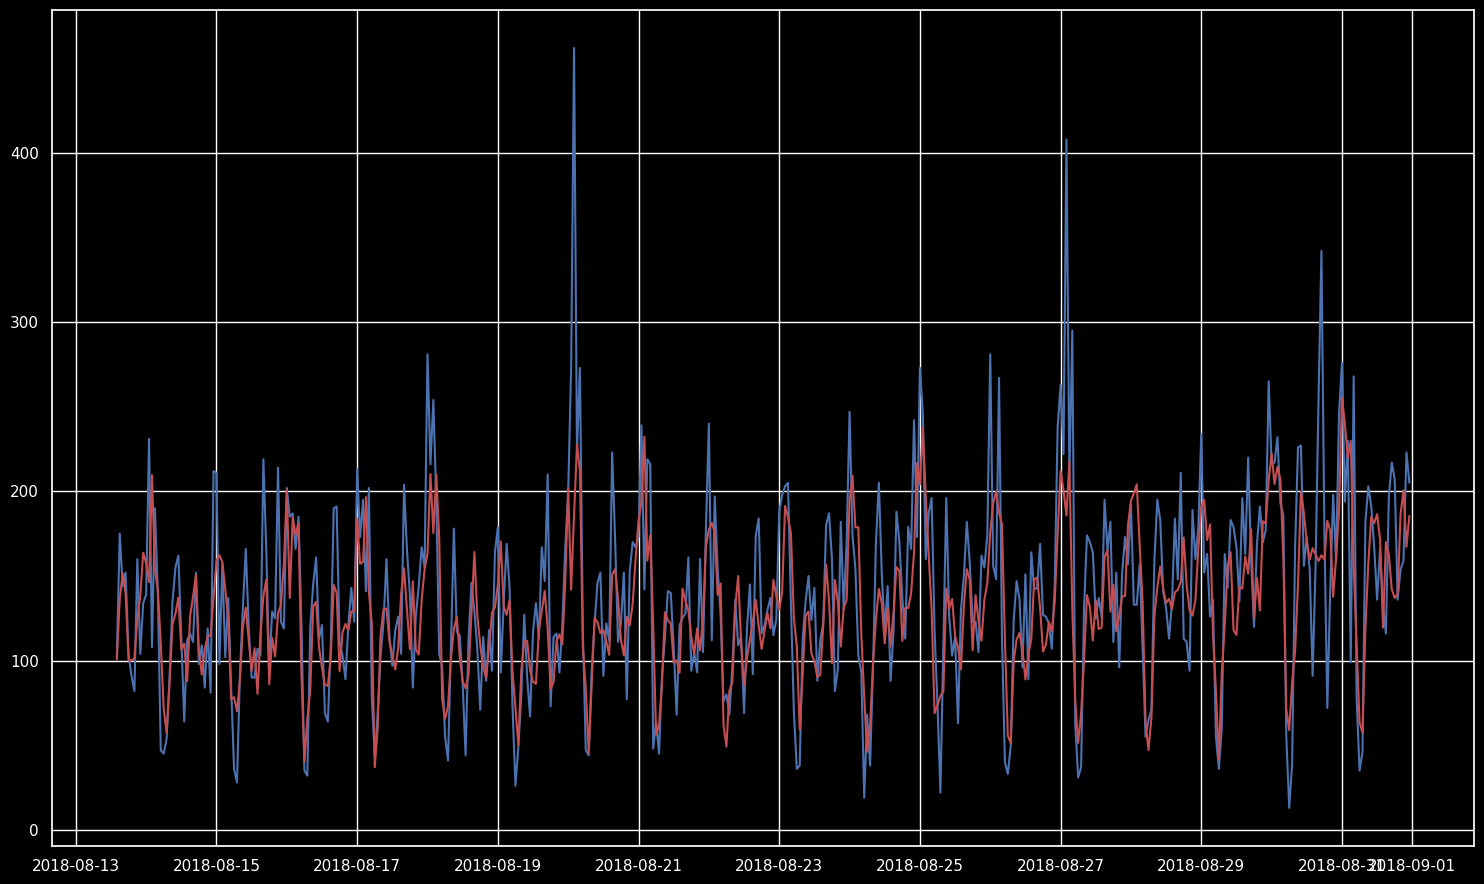

In [37]:
plt.plot(t_test.index,t_test,'b-',t_test.index,predictions,'r-')
plt.show()

Вывод:


Модель LGBMRegressor с подобранными гиперпараметрами выдала rmse на уровне 42.97, что соответствует цели проекта,т.к. итоговый показатель менее 48.

